In [1]:
import joblib
import pandas as pd
import soundfile as sf
import glob
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
from sklearn.metrics import average_precision_score
import copy

os.chdir('/home/lpepino/ast-pe')

In [2]:
class_map = pd.read_csv('../Datasets/Audioset/audioset_class_map.csv')
class_map = class_map.reset_index().set_index('mid')

read_csv_kwarg = {'delimiter': ',',
    'skipinitialspace': True,
    'quotechar': '"',
    'encoding': 'utf-8',
    'header': 2}

df_eval = pd.read_csv('http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/eval_segments.csv', **read_csv_kwarg)
df_eval = df_eval.set_index('# YTID')
eval_wavs = glob.glob('../Datasets/audioset_evaluation/*.wav')

In [5]:
def swa(ckpts_to_avg):
    ckpt_swa = {}
    for ckpt_i in ckpts_to_avg:
        ckpt_i = joblib.load(ckpt_i)
        for k,v in ckpt_i.items():
            if k not in ckpt_swa:
                ckpt_swa[k] = copy.deepcopy(v)
            else:
                for i,w in enumerate(v[0]):
                    ckpt_swa[k][0][i] += w

    for k,v in ckpt_swa.items():
        for i,w in enumerate(ckpt_swa[k][0]):
            ckpt_swa[k][0][i] = ckpt_swa[k][0][i]/len(ckpts_to_avg)

    return ckpt_swa

def eval_model(model, ckpt_path=None, average_ckpts=None):
    INPUT_LEN = 158960
    if average_ckpts is not None:
        ckpt_metadata = joblib.load(Path(ckpt_path,'metadata'))
        ckpt_metadata = {m['step']: m['weights_path'] for m in ckpt_metadata}
        ckpts = list(ckpt_metadata.values())
        to_avg_ckpts = ckpts[-average_ckpts:]
        print('SWA of {}/{} checkpoints'.format(len(to_avg_ckpts),len(ckpts)))
        print(list(ckpt_metadata.keys()))
        swa_ckpt = swa(to_avg_ckpts)
        model.set_weights(swa_ckpt)

    preds = []
    gts = []
    filenames = []
    xs = []
    BATCH_SIZE = 64
    for x in tqdm(eval_wavs):
        gt = np.zeros((len(class_map),))
        for l in df_eval.loc[str(Path(x).stem)]['positive_labels'].split(','):
            gt[class_map.loc[l]['index']] = 1
        gts.append(gt)
        x, fs = sf.read(x)
        filenames.append(x)
        if x.ndim>1:
            x = np.mean(x,axis=1)
        if len(x) < INPUT_LEN:
            x = np.pad(x,(0,INPUT_LEN - x.shape[0]))
        else:
            x = x[:INPUT_LEN]
        xs.append(x)
        if len(xs) == BATCH_SIZE:
            pred = model.predict(np.array(xs))
            preds.append(pred)
            xs = []
    if len(xs) > 0:
        pred = model.predict(np.array(xs))
        preds.append(pred)

    preds = np.concatenate(preds)
    gts = np.stack(gts)
    
    ap = average_precision_score(gts,preds,average=None)
    mAP = np.mean(ap)

    return mAP

In [6]:
model = joblib.load('pretrained_models/abs-pe-encodings-220ksteps.dnn')
abs_best_ckpt_map = eval_model(model)
model = joblib.load('pretrained_models/peg-embeddings-220ksteps.dnn')
peg_best_ckpt_map = eval_model(model)
#swa_maps = [eval_model(model,
#            'cache/29ee2dbd2ca67d07ea6bdc598b0a17352309a770/checkpoints',
#            i) for i in range(37)]

100%|██████████| 16710/16710 [02:32<00:00, 109.29it/s]


In [7]:
abs_swa_map = joblib.load('pretrained_models/swa_maps_abs.jl')[25]
peg_swa_map = joblib.load('pretrained_models/swa_maps_peg.jl')[25]

In [8]:
print('Abs best checkpoint MAP: {:.3f}'.format(abs_best_ckpt_map))
print('Abs SWA MAP: {:.3f}'.format(abs_swa_map))
print('CPEG best checkpoint MAP: {:.3f}'.format(peg_best_ckpt_map))
print('CPEG SWA MAP: {:.3f}'.format(peg_swa_map))

Abs best checkpoint MAP: 0.288
Abs SWA MAP: 0.315
CPEG best checkpoint MAP: 0.321
CPEG SWA MAP: 0.345


In [6]:
joblib.dump(swa_maps,'pretrained_models/swa_maps_abs.jl')

['pretrained_models/swa_maps_abs.jl']

Text(0, 0.5, 'mAP')

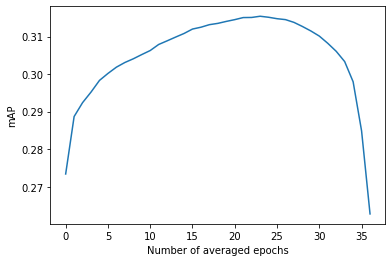

In [5]:
import matplotlib.pyplot as plt

swa_maps.append(swa_maps[0])
swa_maps = swa_maps[1:]

plt.plot(swa_maps)
plt.xlabel('Number of averaged epochs')
plt.ylabel('mAP')

In [43]:
ckpt_1['transformer_encoder_2/TransformerBlock_0'][1]

['transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_mha/transformer_encoder_2/TransformerBlock_0_mha_wq/kernel:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_mha/transformer_encoder_2/TransformerBlock_0_mha_wk/kernel:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_mha/transformer_encoder_2/TransformerBlock_0_mha_wv/kernel:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_mha/transformer_encoder_2/TransformerBlock_0_mha_wo/kernel:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_layernorm_1/gamma:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_layernorm_1/beta:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_layernorm_2/gamma:0',
 'transformer_encoder_2/TransformerBlock_0/transformer_encoder_2/TransformerBlock_0_layernorm_2